## Dataset Overview

We use daily mean OLR (`olr`) from 1979–2000 between 30°S–30°N. The dataset includes dimensions `time`, `lat`, and `lon` and is suitable for demonstrating temporal filtering and spectral analysis.

# Geophysical Signal Tools Tutorial

This tutorial shows how to use the `spectral_analysis` module (`spa`) to:
- Load OLR data with `xarray`
- Compute power spectra
- Apply 1D and 3D filters (lowpass, highpass, bandpass)
- Remove seasonal cycles using harmonic regression

We'll work with the sample dataset `olr.day.mean_1979_2000_30S30N.nc` shipped in this folder.

In [1]:

import spectral_analysis as spa

import numpy as np
import xarray as xr


olr_xr = xr.open_dataset('olr.day.mean_1979_2000_30S30N.nc')

<xarray.Dataset> Size: 116MB
Dimensions:  (time: 8036, nmiss: 7, lat: 25, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 64kB 1979-01-01 1979-01-02 ... 2000-12-31
  * lon      (lon) float32 576B -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat      (lat) float32 100B 30.0 27.5 25.0 22.5 ... -22.5 -25.0 -27.5 -30.0
Dimensions without coordinates: nmiss
Data variables:
    info     (time, nmiss) float32 225kB ...
    olr      (time, lat, lon) float32 116MB 263.4 264.5 252.5 ... 242.5 228.0
Attributes:
    CDI:            Climate Data Interface version 2.5.4 (https://mpimet.mpg....
    Conventions:    CF-1.2
    source:         ftp.cpc.ncep.noaa.gov precip/noaa..
    title:          Daily Mean Interpolated OLR
    description:    Data is interpolated in time and space from NOAA twice-da...
    platform:       Observation
    References:     https://www.psl.noaa.gov/data/gridded/data.interp_OLR.html
    NCO:            4.0.0
    Citation:       Liebmann and Smith: June 2006: D

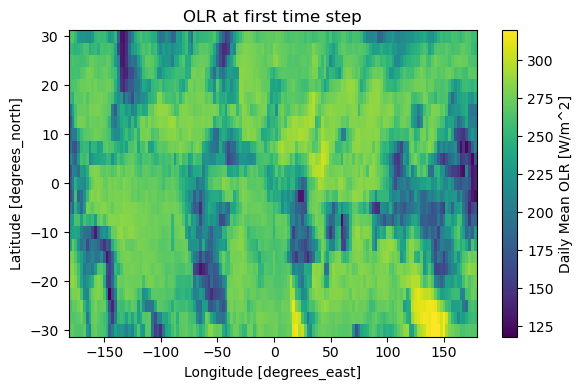

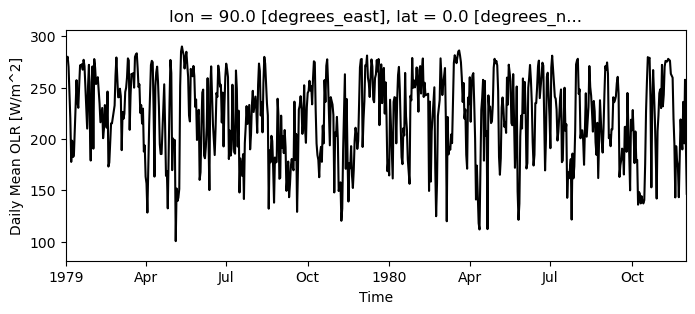

In [27]:
# Inspect dataset and preview
import matplotlib.pyplot as plt

# The dataset was opened above as `olr_xr`
print(olr_xr)
da = olr_xr['olr']
print('dims:', da.dims)
print('shape:', da.shape)

# Plot a map at the first time step
plt.figure(figsize=(6,4))
da.isel(time=0).plot()
plt.title('OLR at first time step')
plt.tight_layout()
plt.show()

lon, lat = 90, 0

# Compute and plot the spatial mean time series
olr_series = olr_xr.sel(lon=lon, lat=lat, method='nearest')['olr']
plt.figure(figsize=(8, 3))
plt.xlim(olr_series['time'].values[0], olr_series['time'].values[700])
olr_series.plot(color='k')


## Power Spectrum

We compute the normalized power spectrum (percentage of variance) of a time series using `spa.compute_power_spectrum()` and plot with `spa.plot_power_spectrum()`.

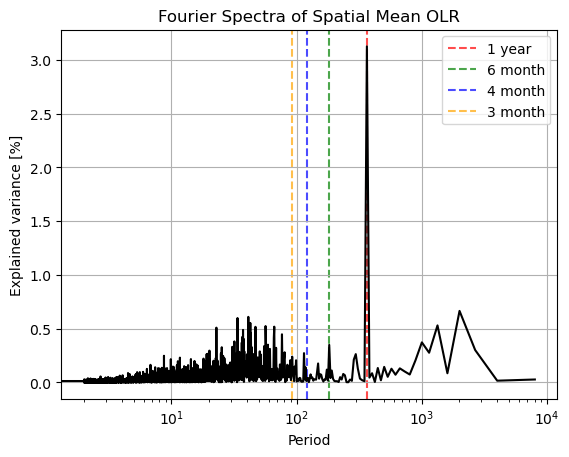

In [ ]:
# Compute and plot power spectrum of spatial mean
periods, pct_var = spa.compute_power_spectrum(olr_series.values)

fig, ax = spa.plot_power_spectrum(olr_series.values)
ax.set_title('Fourier Spectra of Spatial Mean OLR')

# Mark harmonics of the annual cycle
harmonics = {
    365.25: ('1 year', 'red'),
    182.625: ('6 month', 'green'),
    121.75: ('4 month', 'blue'),
    91.3125: ('3 month', 'orange'),
}

for period, (label, color) in harmonics.items():
    ax.axvline(period, color=color, linestyle='--', 
               label=label, zorder=0, alpha=0.7)
ax.legend()


## 1D Filters

We apply filters to a single time series. Here, we use the spatial mean time series for simplicity:
- Lowpass: keeps periods longer than the cutoff
- Highpass: keeps periods shorter than the cutoff
- Bandpass: keeps periods within a period range

Text(0.5, 1.0, 'Bandpass Filtered Spectrum [20-90 days]')

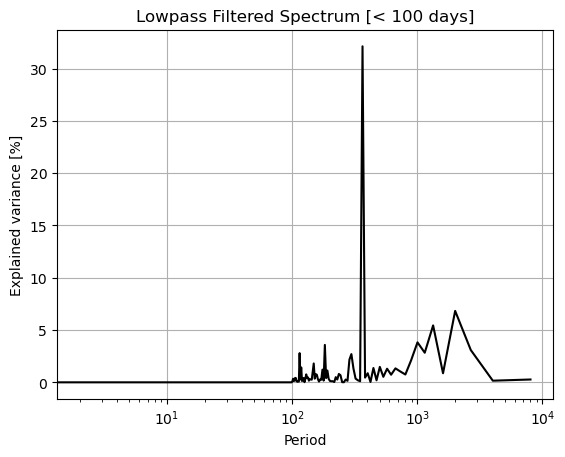

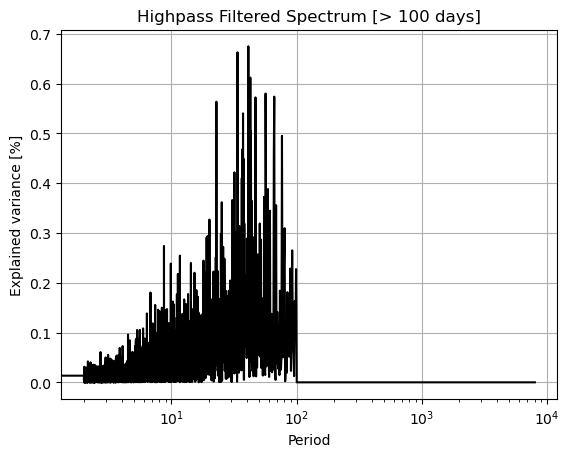

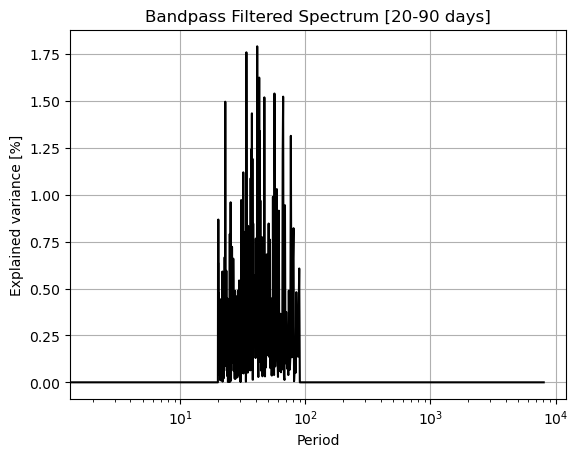

In [23]:
# Apply 1D filters to spatial mean
cutoff_days = 100
bp_low, bp_high = 20, 90

olr_low = spa.lowpass_filter(olr_series.values, cutoff_days)
olr_high = spa.highpass_filter(olr_series.values, cutoff_days)
olr_band = spa.bandpass_filter(olr_series.values, bp_low, bp_high)

fig, ax = spa.plot_power_spectrum(olr_low)
ax.set_title(f'Lowpass Filtered Spectrum [< {cutoff_days} days]')
fig, ax = spa.plot_power_spectrum(olr_high)
ax.set_title(f'Highpass Filtered Spectrum [> {cutoff_days} days]')
fig, ax = spa.plot_power_spectrum(olr_band)
ax.set_title(f'Bandpass Filtered Spectrum [{bp_low}-{bp_high} days]')



## 3D Filters

We apply filters directly to the 3D array `(time, lat, lon)`. These operations can be computationally expensive; start with moderate cutoffs and consider subsetting for performance when needed.

Applying lowpass filter

Input configuration:
  Data shape: (8036, 25, 144) (time=8036, lat=25, lon=144)
  Cutoff period: 100 time units

Processing:
  Reshaped to: (8036, 3600) (time x space)
  Frequencies to remove: 7876 / 8036
  Valid spatial points: 3,600/3,600 (100.0%)

  Status: Complete data - vectorized filtering
  ✓ Filtered all 3,600 points simultaneously

Completed in 0.82 seconds



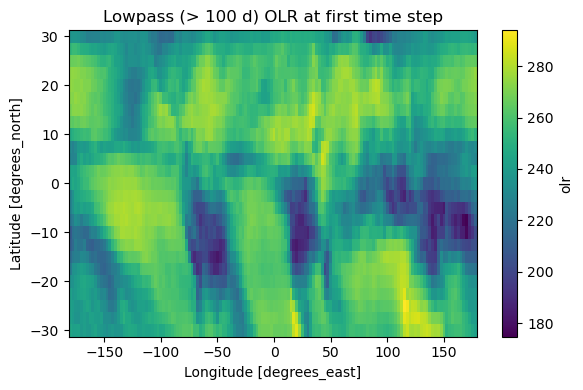

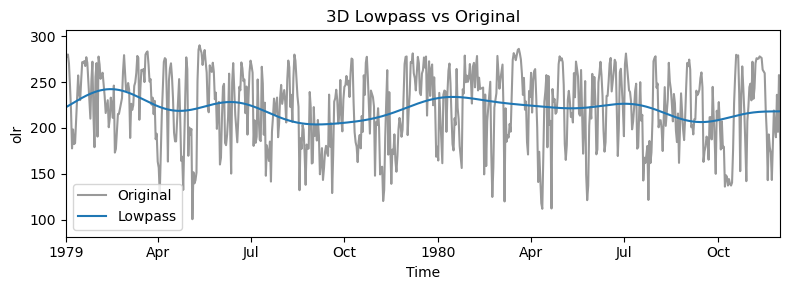

In [24]:
# Lowpass filter 3D data and compare
cutoff_days_3d = 100
olr_low_3d = spa.lowpass_filter_3d(da.values, cutoff_days_3d)

# Wrap back into xarray for plotting
olr_low_xr = xr.DataArray(olr_low_3d, coords=da.coords, dims=da.dims, name='olr')
plt.figure(figsize=(6,4))
olr_low_xr.isel(time=0).plot()
plt.title(f'Lowpass (> {cutoff_days_3d} d) OLR at first time step')
plt.tight_layout()
plt.show()

# Compare spatial mean time series
olr_low_series = olr_low_xr.sel(lon=lon, lat=lat, method='nearest')
plt.figure(figsize=(8,3))
olr_series.plot(color='k', alpha=0.4, label='Original')
olr_low_series.plot(color='tab:blue', label='Lowpass')
plt.xlim(olr_series['time'].values[0], olr_series['time'].values[700])
plt.legend()
plt.title('3D Lowpass vs Original')
plt.tight_layout()
plt.show()

## Seasonal Cycle Removal

Use harmonic regression to remove the seasonal cycle and its harmonics from the full 3D dataset with `spa.remove_seasonal_cycle_harmonic()`.

Removing seasonal cycle with harmonic regression (normal method)

Input configuration:
  Data shape: (8036, 25, 144) (time=8036, lat=25, lon=144)
  Harmonics: 4
  Year period: 365.25 time units
  Method: normal

Processing:
  Reshaped to: (8036, 3600) (time x space)
  Design matrix: (8036, 9) (time x features: 1 constant + 8 harmonics)
  Valid spatial points: 3,600/3,600 (100.0%)

  Status: Complete data - vectorized regression
  ✓ Processed all 3,600 points simultaneously

Completed in 0.38 seconds



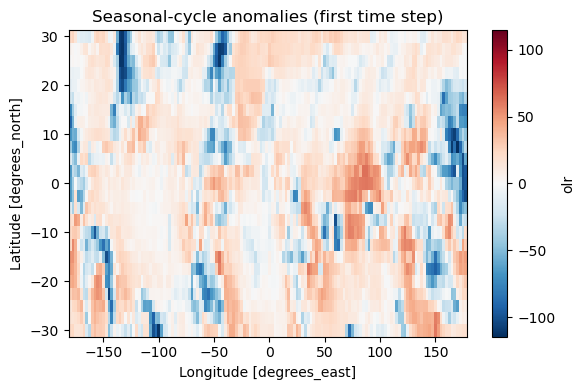

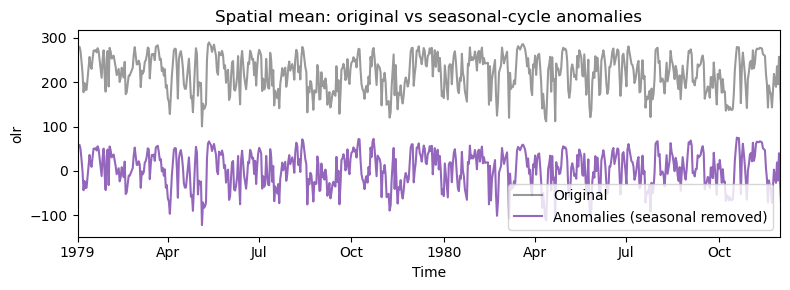

In [25]:
# Remove seasonal cycle with harmonic regression (3D)
n_harmonics = 4
year_period_days = 365.25
anoms_3d = spa.remove_seasonal_cycle_harmonic(da.values,
                                              n_harmonics=n_harmonics,
                                              year_period=year_period_days,
                                              method='normal')

anoms_xr = xr.DataArray(anoms_3d, coords=da.coords, dims=da.dims, name='olr')

# Plot map of anomalies at first time step
plt.figure(figsize=(6,4))
anoms_xr.isel(time=0).plot()
plt.title('Seasonal-cycle anomalies (first time step)')
plt.tight_layout()
plt.show()

# Compare spatial mean before/after
anoms_mean = anoms_xr.sel(lon=lon, lat=lat, method='nearest')
plt.figure(figsize=(8,3))
olr_series.plot(color='k', alpha=0.4, label='Original')
anoms_mean.plot(color='tab:purple', label='Anomalies (seasonal removed)')
plt.xlim(olr_series['time'].values[0], olr_series['time'].values[700])
plt.legend()
plt.title('Spatial mean: original vs seasonal-cycle anomalies')
plt.tight_layout()
plt.show()

## Summary

- Loaded OLR data with `xarray` and previewed dimensions.
- Computed and plotted the Fourier power spectrum of a time series.
- Applied 1D filters (lowpass, highpass, bandpass) to the spatial mean.
- Applied 3D filters to the full dataset and visualized maps/time series.
- Removed the seasonal cycle via harmonic regression and compared anomalies.

Tip: For performance, subset the grid or time window for experimentation, then scale up once parameters are finalized.